## Import libaries

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
!pip install xgboost
import warnings


warnings.filterwarnings("ignore")

## Import and transform the dataset

In [19]:
filepath = "/kaggle/input/insurance/insurance.csv"
df = pd.read_csv(filepath)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
df["sex"] = df["sex"].map({"female":0, "male":1})
df["smoker"] = df["smoker"].map({"no":0, "yes":1})
new_df = pd.get_dummies(df, dtype=int)
new_df.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## Split dataset in to train and test

In [21]:
from  sklearn.model_selection import train_test_split
X = new_df.drop("charges", axis = "columns")
y = new_df["charges"]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size = 0.2, shuffle = False)


## Grid Search to find the best parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid_linear = {
    "booster": ["gblinear"],
    "eta": [0.01, 0.05, 0.1],
    "alpha": [0, 0.1, 0.5],
    "lambda": [0, 0.1, 0.5],
    "lambda_bias": [0, 0.1],
    "updater": ["shotgun", "coord_descent"],
    "feature_selector": ["cyclic", "shuffle"],
    "tolerance": [1e-4, 1e-5],
    "objective": ["reg:squarederror", "reg:pseudohubererror"]
}

model = XGBRegressor( n_estimators=200,random_state=42, n_jobs=-1              
)

grid = GridSearchCV(estimator=model,param_grid=param_grid_linear,scoring="r2",verbose=2)

grid.fit(X_train, y_train)

best_params = grid.best_params_       
best_score = grid.best_score_      
print("Best Parameters:", best_params)
print("Best CV Score:", best_score)

test_score = grid.score(X_test, y_test) 
print("Test R²:", test_score)

Best paramters found after the Grid Search

In [8]:
best_params = {'alpha': 0, 'booster': 'gblinear', 'eta': 0.1, 'feature_selector': 'shuffle', 'lambda': 0, 'lambda_bias': 0, 'objective': 'reg:squarederror', 'tolerance': 0.0001, 'updater': 'coord_descent'}     
best_score = 0.7081388533425446    
test_score = 0.7563193917288837 

## Random Search for multiple parameters combination

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
param_grid_linear = {
    "booster": ["gblinear"],
    "eta": [0.01, 0.05, 0.1, 0.2, 0.3], 
    "alpha": [0, 0.01, 0.05, 0.1, 0.5],    
    "lambda": [0, 0.01, 0.05, 0.1, 0.5],    
    "lambda_bias": [0, 0.01, 0.05, 0.1],    
    "updater": ["coord_descent", "shotgun"],      
    "feature_selector": ["cyclic", "shuffle", "random"],  
    "tolerance": [1e-3, 1e-4, 1e-5, 1e-6],        
    "objective": ["reg:squarederror", "reg:pseudohubererror"],
    "top_k": [0, 50, 100], 
}

model = XGBRegressor(random_state=42)

grid = RandomizedSearchCV(estimator=model,param_distributions=param_grid_linear, n_iter=250,cv=3,scoring="r2",n_jobs=-1)

grid.fit(X_train, y_train)

best_params = grid.best_params_       
best_score = grid.best_score_      
print("Best Parameters:", best_params)
print("Best CV Score:", best_score)

test_score = grid.score(X_test, y_test) 
print("Test R²:", test_score)

Best paramters from Random Search, better than Grid Search

In [22]:
params = {'updater': 'coord_descent', 'top_k': 100, 'tolerance': 1e-05, 'objective': 'reg:squarederror', 'lambda_bias': 0.01, 'lambda': 0, 'feature_selector': 'cyclic', 'eta': 0.3, 'booster': 'gblinear', 'alpha': 0.5}
cv_score =  0.7203969542327864
r2_score = 0.7684421356844305

## Fit and train the model

In [23]:
from xgboost import XGBRegressor
model = XGBRegressor(**params, random_state = 42)
model.fit(X_train, y_train)

XGBRegressor(alpha=0.5, base_score=None, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_selector='cyclic', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=0, lambda_bias=0.01,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, ...)

## Weight and bias of the trained model

In [24]:
feat = model.get_booster().feature_names
weight = coef = model.get_booster().get_dump(dump_format='json')
print(feat, weight)

features_values = pd.DataFrame({
    "Values" : [-7284.28,244.876,-393.978,102.972,367.047,23389.5,-9958.67, -10502.2, -10121.8,-10909.6,],
"Parameters" :["Bias","Age","Sex","BMI","Children","Smoker","Northeast","Northwest","Southeast","Soutwest"] } ,    
index = [1,2,3,4,5,6,7,8,9,10])

features_values


['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'] ['  { "bias": [\n      -7284.28\n    ],\n    "weight": [\n      244.876,\n      -393.978,\n      102.972,\n      367.047,\n      23389.5,\n      -9958.67,\n      -10502.2,\n      -10121.8,\n      -10909.6\n    ]\n  }']


,Values,Parameters
1,-7284.280,Bias
2,244.876,Age
3,-393.978,Sex
4,102.972,BMI
5,367.047,Children
6,23389.500,Smoker
7,-9958.670,Northeast
8,-10502.200,Northwest
9,-10121.800,Southeast
10,-10909.600,Soutwest


## Prediction measuremnt of the model

In [25]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = model.predict(X_test)
print("Mean Absolute Error: "+str(mean_absolute_error(y_test,y_pred)))
print("R2 Score: "+str(r2_score(y_test,y_pred)))

Mean Absolute Error: 4178.996033573927
R2 Score: 0.7448590678164438


The model performed poorly with the test dataset. To find the underlying problem, we need to visualize the situation

## Visualization of the model

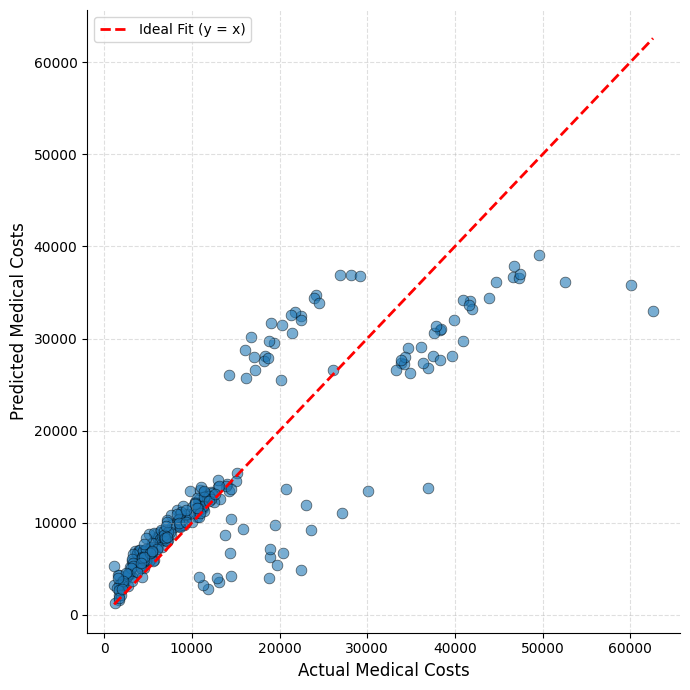

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

df_new = pd.DataFrame({"Actual": y_test, "Prediction": y_pred})

plt.figure(figsize=(7,7))
sns.scatterplot(data=df_new, x="Actual", y="Prediction", s=60, alpha=0.6, edgecolor='k', linewidth=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', lw=2, label="Ideal Fit (y = x)")
plt.xlabel("Actual Medical Costs", fontsize=12)
plt.ylabel("Predicted Medical Costs", fontsize=12)
plt.legend()
sns.despine()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Here we can see that the model predictions don't go over the value of 40 000. Therefore the actual cost value over 40 000 decrease the models R2 score, the model predicts fairly well till the price range of 30 000

<Axes: xlabel='Parameters', ylabel='Values'>

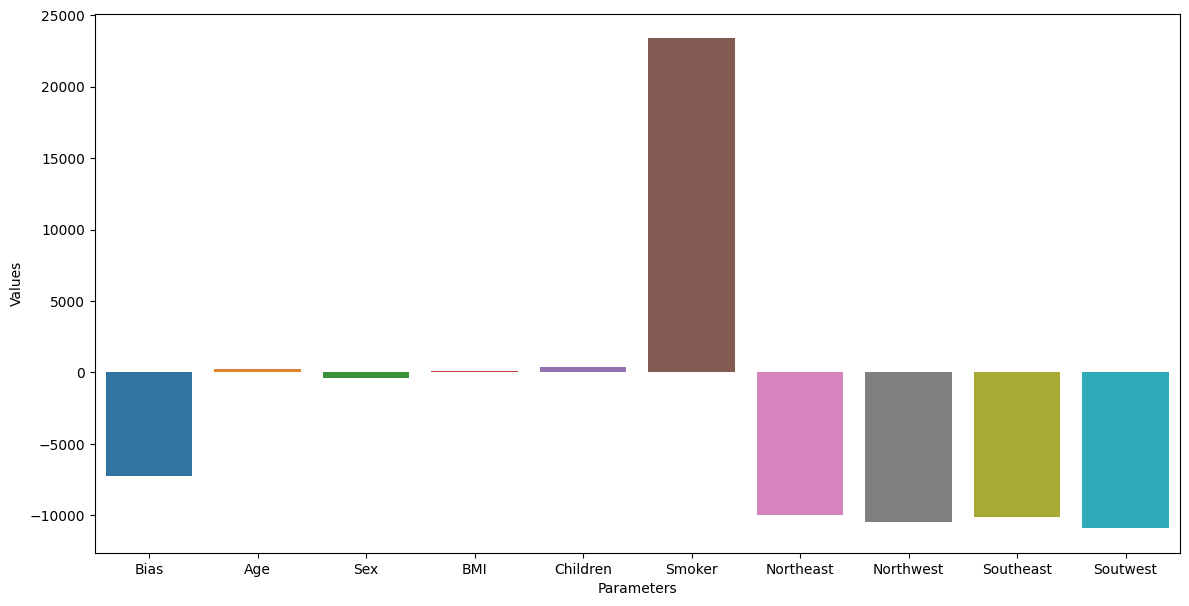

In [27]:
plt.figure(figsize=(14,7))
sns.barplot(x ="Parameters", y = "Values" ,data=features_values)

The most influential features in the model are smoker and the regions.

## Learning Curve

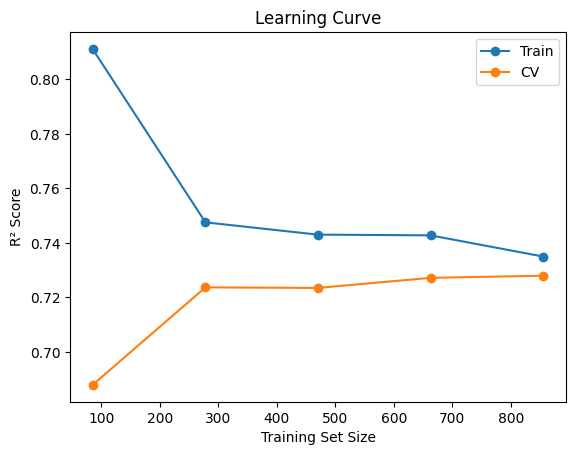

In [32]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='r2')
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="CV")
plt.legend()
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve")
plt.show()

## Actual vs Predicted Distribution

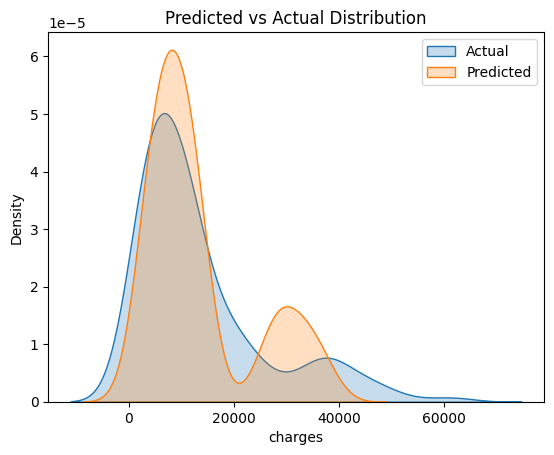

In [34]:
sns.kdeplot(y_test, label="Actual", shade=True)
sns.kdeplot(y_pred, label="Predicted", shade=True)
plt.title("Predicted vs Actual Distribution")
plt.legend()
plt.show()


## Distribution of Residuals

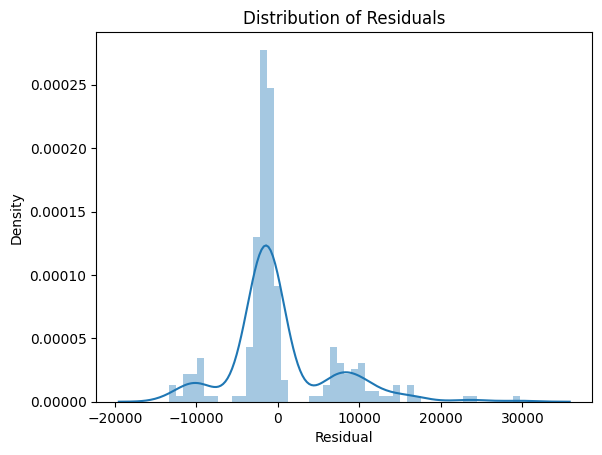

In [36]:
residuals = y_test - y_pred
sns.distplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.show()
